In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install --upgrade polars==0.19.19 -q

In [ ]:
#! pip install cudf-cu11 --extra-index-url=https://pypi.nvidia.com -q
#%load_ext cudf.pandas
import pandas as pd

In [ ]:
import os
from glob import glob

#import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from contextlib import contextmanager
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil

%matplotlib inline


# ref: Kaggleコード遺産 https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5
class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

# 再現性確保!
SEED = 890
seed_everything(SEED)

In [ ]:
import requests
from tqdm import tqdm
from pathlib import Path


COMPETITION_NAME = "atma16"
EXP_NAME = requests.get("http://172.28.0.12:9000/api/sessions").json()[0]["name"][:-6]

HOME = Path(f"/content/drive/MyDrive/{COMPETITION_NAME}")
INPUT_DIR = Path(f"/content/drive/MyDrive/{COMPETITION_NAME}/inputs")
OUTPUT_DIR = Path(f"/content/drive/MyDrive/{COMPETITION_NAME}/outputs/{EXP_NAME}")

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# 学習用のログデータと正解ラベル
train_log_df = pd.read_csv(INPUT_DIR / "train_log.csv")
train_label_df = pd.read_csv(INPUT_DIR / "train_label.csv")

# 宿のデータ
yado_df = pd.read_csv(INPUT_DIR / "yado.csv")

# テスト期間のログデータ
test_log_df = pd.read_csv(INPUT_DIR / "test_log.csv")

sample_submission_df = pd.read_csv(INPUT_DIR / "sample_submission.csv")

# すべてのログデータはあとあと参照をするので先に作っておきます.
whole_log_df = pd.concat([train_log_df, test_log_df], ignore_index=True)

In [ ]:
def create_yado_popularity():
    # clickや予約に基づいて人気順を作成
    # click: train_log + train_label_df + test_log
    # reserve: train_label_df

    yado_df = pd.read_csv(INPUT_DIR / "yado.csv")

    test_log = pd.read_csv(INPUT_DIR / "test_log.csv")
    train_log = pd.read_csv(INPUT_DIR / "train_log.csv")

    # train, testでのクリック数(leakのない人気順のようなもの)
    whole_click_log = whole_log_df[["session_id", "yad_no"]].drop_duplicates().groupby("yad_no").size()
    yado_df["whole_click_count"] = yado_df["yad_no"].map(whole_click_log).fillna(0)

    # 画像の枚数とか
    image_embeddings = pd.read_parquet(INPUT_DIR / "image_embeddings.parquet")
    yad_image_agg_meta = image_embeddings.groupby(['yad_no', 'category']).size().rename('category_image_counts').reset_index()\
                                                .pivot(index="yad_no", columns="category", values='category_image_counts').fillna(0)
    yad_image_agg_meta["num_total_images"] = yad_image_agg_meta.sum(axis=1)  #.reset_index()
    yado_df = yado_df.merge(yad_image_agg_meta, on="yad_no", how="left")

    #yado_df.merge(train_log_df.groupby('yad_no').size(), on="yad_no", how='left')
    yado_df["train_click_counts"] = yado_df["yad_no"].map(train_log_df[["session_id", "yad_no"]].drop_duplicates().groupby('yad_no').size().to_dict()).fillna(0)
    yado_df["test_click_counts"] = yado_df["yad_no"].map(test_log_df[["session_id", "yad_no"]].drop_duplicates().groupby('yad_no').size().to_dict()).fillna(0)

    for image_col in ['exterior', 'facility', 'food', 'others', 'room', 'num_total_images']:
        yado_df[image_col] = yado_df[image_col].fillna(0).astype('int8')

    return yado_df

yado_df = create_yado_popularity()
yado_df.columns

Index(['yad_no', 'yad_type', 'total_room_cnt', 'wireless_lan_flg', 'onsen_flg',
       'kd_stn_5min', 'kd_bch_5min', 'kd_slp_5min', 'kd_conv_walk_5min',
       'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'whole_click_count', 'exterior',
       'facility', 'food', 'others', 'room', 'num_total_images',
       'train_click_counts', 'test_click_counts'],
      dtype='object')

## CVの作成

In [ ]:
train_log_df.groupby('session_id').tail(1)

,session_id,seq_no,yad_no
0,000007603d533d30453cc45d0f3d119f,0,2395
1,0000ca043ed437a1472c9d1d154eb49b,0,13535
2,0000d4835cf113316fe447e2f80ba1c8,0,123
3,0000fcda1ae1b2f431e55a7075d1f500,0,8475
5,000104bdffaaad1a1e0a9ebacf585f33,1,898
...,...,...,...
419262,ffff2262d38abdeb247ebd591835dcc9,0,8140
419263,ffff2360540745117193ecadcdc06538,0,2121
419264,ffff7fb4617164b2604aaf51c40bf82d,0,7183
419267,ffffcd5bc19d62cad5a3815c87818d83,2,12230


In [ ]:
train_log_df.groupby('session_id').tail(1)[["session_id", "yad_no"]].reset_index(drop=True)

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,2395
1,0000ca043ed437a1472c9d1d154eb49b,13535
2,0000d4835cf113316fe447e2f80ba1c8,123
3,0000fcda1ae1b2f431e55a7075d1f500,8475
4,000104bdffaaad1a1e0a9ebacf585f33,898
...,...,...
288693,ffff2262d38abdeb247ebd591835dcc9,8140
288694,ffff2360540745117193ecadcdc06538,2121
288695,ffff7fb4617164b2604aaf51c40bf82d,7183
288696,ffffcd5bc19d62cad5a3815c87818d83,12230


In [ ]:
from sklearn.model_selection import GroupKFold, StratifiedKFold


N_FOLD = 5
sess_lengths = train_log_df.groupby(['session_id'])["seq_no"].max().rename('seq_length').reset_index()
sess_last_yad = train_log_df.groupby('session_id').tail(1)[["session_id", "yad_no"]].reset_index(drop=True)
fold = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=42)
# cv = fold.split(sess_lengths, y=sess_lengths["seq_length"].values)
cv = fold.split(sess_last_yad, y=sess_last_yad["yad_no"].values)
cv = list(cv) # split の返り値は generator なので list 化して何度も iterate できるようにしておく
sess_lengths["fold"] = -1
for i_fold, (train_idx, valid_idx) in enumerate(cv):
    sess_lengths.loc[valid_idx, "fold"] = i_fold
sess2fold = sess_lengths.set_index('session_id')["fold"].to_dict()
train_label_df["fold"] = train_label_df["session_id"].map(sess2fold)
train_log_df["fold"] = train_log_df["session_id"].map(sess2fold)
train_log_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,session_id,seq_no,yad_no,fold
0,000007603d533d30453cc45d0f3d119f,0,2395,0
1,0000ca043ed437a1472c9d1d154eb49b,0,13535,0
2,0000d4835cf113316fe447e2f80ba1c8,0,123,2
3,0000fcda1ae1b2f431e55a7075d1f500,0,8475,4
4,000104bdffaaad1a1e0a9ebacf585f33,0,96,1


# 候補の作成
- sessionに対してyad_noを紐づける．　特徴量作成とは明確に分離する

In [ ]:
%%time
def remove_last_seq_post_process(candidate, log):
    max_seq_no = log.group_by("session_id").agg(pl.max("seq_no").alias("max_seq_no"))
    _log = log.join(max_seq_no, on="session_id", how='left')

    # sessionごとに最後に閲覧したyad
    sess2_max_seq_yad = _log.filter(pl.col("seq_no") == pl.col("max_seq_no")).select(['session_id','yad_no']).unique()
    return candidate.join(sess2_max_seq_yad, on=["session_id"], how="left")\
                    .filter(pl.col("yad_no") != pl.col("yad_no_right"))\
                    .select(['session_id', 'yad_no'])

def get_session_id_list(log):
    return log.group_by('session_id').head(1).select(['session_id'])

CPU times: user 8 µs, sys: 3 µs, total: 11 µs
Wall time: 14.8 µs


In [ ]:
def create_past_view_yado_candidates(log):
    """
    アクセスした宿をcandidateとして作成。ただし、直近の宿は予約しないので除外する。
    """
    max_seq_no = log.group_by("session_id").agg(pl.max("seq_no").alias("max_seq_no"))
    _log = log.join(max_seq_no, on="session_id", how='left')

    # sessionごとに最後に閲覧したyad
    max_seq_yad = _log.filter(pl.col("seq_no") == pl.col("max_seq_no")).select(['session_id','yad_no']).unique()
    past_yado_candidates = log.join(max_seq_yad.rename({'yad_no': 'max_seq_yad_no'}), on="session_id", how='left')
    past_yado_candidates = past_yado_candidates.filter(pl.col("yad_no") != pl.col("max_seq_yad_no"))\
                                                   .select(['session_id','yad_no']).unique().sort(['session_id', 'yad_no'])

    return past_yado_candidates

In [ ]:
def create_next_click_yad_counts(input_log_pl: pl.DataFrame):
    next_seq_log = input_log_pl.with_columns(pl.col('seq_no')+1)[['session_id', 'seq_no', 'yad_no']].rename({'yad_no':'next_yad_no'})
    # session_idとseq_noでjoin
    log_next_seq = input_log_pl.join(next_seq_log, how='left', on=['session_id', 'seq_no']).filter(pl.col('next_yad_no').is_not_null())

    log_next_seq_candidate =  log_next_seq.group_by(['yad_no', 'next_yad_no']).count() \
                                             .sort(by=['yad_no', 'count'], descending=[False,True]) \
                                             .with_columns(pl.col("count").cast(pl.Float64))
                                             #.rename({'yad_no':'latest_yad_no', 'next_yad_no':'yad_no'})
    return log_next_seq_candidate.with_columns(pl.col("count").cast(pl.Float64))

label = pl.from_pandas(train_label_df)

train_log = pl.read_csv(INPUT_DIR / "train_log.csv")
train_session_id = get_session_id_list(train_log)
train_session_id = train_session_id.join(label.select(['fold', 'session_id']),how='left',on='session_id')

test_log = pl.read_csv(INPUT_DIR / "test_log.csv")
test_session_id = get_session_id_list(test_log)

# 正例データのseq_no
sess2_label_seq_no = train_log.with_columns(pl.col('seq_no')+1).group_by('session_id').max().select(['session_id', 'seq_no'])
label = label.join(sess2_label_seq_no, on="session_id", how="left").select(['session_id', 'seq_no', 'yad_no', 'fold'])
leak_matrix = create_next_click_yad_counts(
    pl.concat([
        train_log[["session_id", "yad_no", "seq_no"]],
        label[["session_id", "yad_no", "seq_no"]]
    ])
).with_columns(pl.col('count')*0.001)  #trainのはめっちゃ薄める
test_matrix = create_next_click_yad_counts(test_log)
leak_mix_counts = test_matrix.join(leak_matrix, on=["yad_no", 'next_yad_no'], how="outer")\
                               .rename({'count': 'count_left'}) \
                               .with_columns((pl.col('count_left').fill_null(0) + pl.col('count_right').fill_null(0)).alias('count'))


next_click_counts_pl = pl.concat([
    create_next_click_yad_counts(train_log).with_columns(pl.lit(-1).alias('fold')),  # trainの生ログ (targetなし)
    create_next_click_yad_counts(test_log).with_columns(pl.lit(-2).alias('fold')),  #test
    leak_mix_counts.select(['yad_no', 'next_yad_no', 'count']).with_columns(pl.lit(-3).alias('fold'))  # test + train + target
])


for i_fold in range(5):
    # データの取り方
    # oof使う，　foldのデータはfold内で処理, 色々...

    seq_df = pl.concat([
        #train_log,
        train_log.join(label.select(['session_id', 'fold']), on="session_id", how="left").filter(pl.col('fold')!=i_fold).select(['session_id', 'seq_no', 'yad_no']),
        label.filter(pl.col('fold')!=i_fold).select(['session_id', 'seq_no', 'yad_no'])
    ]).sort(['session_id', 'seq_no'])

    # output: ['latest_yad_no', 'yad_no', 'count']
    next_click_counts_pl = pl.concat([
        next_click_counts_pl,
        create_next_click_yad_counts(seq_df).with_columns(pl.lit(i_fold).alias('fold'))
    ])

#next_click_counts_pl = next_click_counts_pl.sort(['fold', 'latest_yad_no', 'count'], descending=[False, False, True])
next_click_counts_pl = next_click_counts_pl.sort(['fold', 'yad_no', 'count'], descending=[False, False, True])
next_click_counts_pl["fold"].value_counts()

fold,counts
i32,u32
-3,199065
-2,42998
-1,68523
0,169424
1,169454
2,169315
3,169308
4,169261


In [ ]:
def generate_co_visit_matrix(df:pl.DataFrame) -> pl.DataFrame:
    # 共起ペアの作成
    df = df.join(df, on="session_id")
    # yad_noが同じものは除外する
    df = df.filter(pl.col("yad_no") != pl.col("yad_no_right"))
    # yad_noのペアごとに共起回数を計算
    df = df.group_by(["yad_no", "yad_no_right"]).count()
    # 整形
    df = df.rename(
        {
            'yad_no': 'latest_yad_no',
            "yad_no_right": "yad_no",
            "count": "co_visit_count",
        }
    )[["latest_yad_no", "yad_no", "co_visit_count"]]

    return df.sort(['latest_yad_no','co_visit_count'],descending=[False,True])


In [ ]:
import os
from typing import Optional

import networkx as nx
import pandas as pd
from tqdm import tqdm


def networkx_base_candidate(_co_visit_matrix):
    # 無向グラフとして表現する
    G = nx.Graph()
    for u, v, weight in _co_visit_matrix[["latest_yad_no", "yad_no", "co_visit_count"]].to_numpy():
        G.add_edge(u, v, weight=1)  #重み付き最短経路を得ようとしたら 100年かかる

    # 後の処理のためにグラフに含まれる"yad_no"のみのデータフレームを作成する
    node_df = pd.DataFrame({"yad_no": sorted(G.nodes)})
    node_df["degree"] = node_df["yad_no"].map(nx.degree(G))
    node_df["clustering"] = node_df["yad_no"].map(nx.clustering(G))

    candidates_dict = {}
    hop_distances_dict = {}
    for yad_no in node_df["yad_no"].to_numpy():
        ego_G = nx.ego_graph(G, yad_no, radius=3)
        candidates = [c for c in ego_G.nodes if c != yad_no]
        hop_distances = {c: nx.shortest_path_length(G, yad_no, c) for c in candidates}
        candidates_dict[yad_no] = candidates
        hop_distances_dict[yad_no] = hop_distances

    # DataFrameに変換
    yad_no_list = []
    candidates_list = []
    hop_distances_list = []
    for key, values in candidates_dict.items():
        for v in values:
            yad_no_list.append(key)
            candidates_list.append(v)
            hop_distances_list.append(hop_distances_dict[key][v])

    # 候補と距離の作成
    candidates_df = pd.DataFrame({
        "yad_no": yad_no_list,
        "candidate_yad_no": candidates_list,
        "hop_distance": hop_distances_list
    })
    return candidates_df

In [ ]:
label = pl.from_pandas(train_label_df)

train_log = pl.read_csv(INPUT_DIR / "train_log.csv")
train_session_id = get_session_id_list(train_log)
train_session_id = train_session_id.join(label.select(['fold', 'session_id']),how='left',on='session_id')

test_log = pl.read_csv(INPUT_DIR / "test_log.csv")
test_session_id = get_session_id_list(test_log)
# 各candidateを結合
candidate_list = {}
candidate_list['train'] = []
candidate_list['test'] = []

for train_test in tqdm(['train','test']):
    if train_test == 'train':
        input_log = train_log.clone()
    else:
        input_log = test_log.clone()
    ## last 除いた session中のyad
    candidate_list[train_test].append(create_past_view_yado_candidates(input_log))

    ## session最後の宿から次にclickするやつ
    if train_test == 'train':
        i_fold = -1
    else:
        #i_fold = -2
        i_fold = -3

    # 末尾のyadに対して順方向  # .sort(['session_id'])
    candidate_list[train_test].append(
        input_log.group_by('session_id').last().join(next_click_counts_pl.filter(pl.col('fold')==i_fold), on=["yad_no"], how="left")\
                                              .sort(['session_id', 'count'], descending=[False, True])\
                                              .group_by('session_id').head(50) \
                                              .select(['session_id', 'next_yad_no']).rename({'next_yad_no': 'yad_no'})
    )

    # 末尾のyadに対して逆方向
    reverse_next_click_counts_pl = next_click_counts_pl.filter(pl.col('fold')==i_fold).rename({'next_yad_no': 'yad_no', 'yad_no': 'next_yad_no'})\
                                                .group_by(['yad_no', 'next_yad_no']).agg(pl.col("count").sum()).sort(['yad_no', 'next_yad_no'])
    candidate_list[train_test].append(
        input_log.group_by('session_id').last().join(reverse_next_click_counts_pl, on=["yad_no"], how="left")\
                                              .sort(['session_id', 'count'], descending=[False, True])\
                                              .group_by('session_id').head(50)\
                                              .select(['session_id', 'next_yad_no']).rename({'next_yad_no': 'yad_no'})
    )
    """
    # sessionのyad全体に対して順方向
    candidate_list[train_test].append(
        input_log.join(next_click_counts_pl.filter(pl.col('fold')==i_fold), on=["yad_no"], how="left")\
                                           #.group_by(['session_id', 'next_yad_no']).agg(pl.col('count').sum())\
                                           .sort('session_id').select(['session_id', 'next_yad_no']).rename({'next_yad_no': 'yad_no'})
    )"""

    # 地域の人気宿
    yado_pl = pl.read_csv(INPUT_DIR / "yado.csv")
    region_params = {
        'sml_cd': 25,  #25
        'lrg_cd': 10,
        'ken_cd': 6,  # 3  #7で10けん確保
    }
    for reg_col, top_n in region_params.items():
        # 人気の定義はtrain / test でのクリック数
        ## 地域ごとの宿のcount数 top_n
        ## どうしてもtestの方が件数減ってしまうのでtrainで穴埋めしても良いかも
        if train_test == 'train':
            region2_popular_yad = input_log.select(['session_id', 'yad_no']).unique().group_by('yad_no').count().join(yado_pl, on="yad_no", how="left")\
                                             .sort(["count", 'yad_no'], descending=[True, True]).group_by(reg_col).head(top_n).select([reg_col, 'yad_no'])
        else:
            tmp_df = pl.concat([
                train_log.select(["session_id", "yad_no"]).with_columns(pl.lit(0.001).alias('count')),
                label.select(["session_id", "yad_no"]).with_columns(pl.lit(0.002).alias('count')),
                test_log.select(["session_id", "yad_no"]).with_columns(pl.lit(1.0).alias('count'))
            ]).unique()
            region2_popular_yad = tmp_df.group_by('yad_no').sum().join(yado_pl, on="yad_no", how="left")\
                                          .sort(["count", 'yad_no'], descending=[True, True]).group_by(reg_col).head(top_n).select([reg_col, 'yad_no'])

        sess2_region = input_log.join(yado_pl, on="yad_no", how="left").select(['session_id', reg_col]).unique()
        candidate_list[train_test].append(
            sess2_region.join(region2_popular_yad, on=reg_col, how="left")\
                         .sort('yad_no').select(['session_id', 'yad_no']).unique()
        )


    # 共起行列
    co_visit_matrix = generate_co_visit_matrix(input_log.select(['session_id', 'yad_no']).unique())
    # 末尾のyadに候補を紐付け / session全体に対して推論
    for target_log in [input_log.group_by('session_id').last(), input_log.select(['session_id', 'yad_no']).unique()]:
        # session ごとに 候補のyad_no
        co_visits_next_yad_counts = target_log.join(co_visit_matrix, on=["yad_no"], how="left").rename({'yad_no': 'latest_yad_no', 'latest_yad_no': 'yad_no'})
        sess2_co_visits_next_yad_counts = co_visits_next_yad_counts.group_by(['session_id', 'yad_no']).agg(pl.col("co_visit_count").sum()) \
                                                                        .sort(['session_id', 'co_visit_count', 'yad_no'], descending=[False, True, True])
        #head(10)
        candidate_list[train_test].append(
            sess2_co_visits_next_yad_counts.group_by('session_id').head(10) \
                                            .select(['session_id', 'yad_no'])
        )



    # testだけを対象にガンガンにリークさせた共起行列
    if train_test == 'test':
        _df = pd.concat([
            train_log_df[["session_id", "yad_no"]],
            train_label_df[["session_id", "yad_no"]],
            test_log_df[["session_id", "yad_no"]],
        ], axis=0, ignore_index=True)
        leak_co_visit_matrix = generate_co_visit_matrix(pl.from_pandas(_df).unique())
        co_visits_next_yad_counts = test_log.join(leak_co_visit_matrix, on=["yad_no"], how="left").rename({'yad_no': 'latest_yad_no', 'latest_yad_no': 'yad_no'})
        sess2_co_visits_next_yad_counts = co_visits_next_yad_counts.group_by(['session_id', 'yad_no']).agg(pl.col("co_visit_count").sum()) \
                                                                        .sort(['session_id', 'co_visit_count'], descending=[False, True])

        candidate_list[train_test].append(
            sess2_co_visits_next_yad_counts.group_by('session_id').head(10)\
                                              .select(['session_id', 'yad_no'])
        )

    """
    if train_test == 'train':
        train_networkx_distance = networkx_base_candidate(
            generate_co_visit_matrix(train_log.select(['session_id', 'yad_no']).unique())
        )
        train_networkx_candidate = input_log.select(['session_id', 'yad_no']).unique().join(pl.from_pandas(train_networkx_distance), on="yad_no", how="left")\
                                                     .sort(['session_id', 'hop_distance'], descending=[False, False])\
                                                     .group_by('session_id').head(10)\
                                                     .select(['session_id', 'candidate_yad_no']).rename({'candidate_yad_no': 'yad_no'})
        candidate_list[train_test].append(train_networkx_candidate)
    else:
        test_leak_co_visit_counts = generate_co_visit_matrix(
            pl.concat([
                train_log.select(["session_id", "yad_no"]),
                label.select(["session_id", "yad_no"]),
                test_log.select(["session_id", "yad_no"])
            ]).unique()
        )
        test_leak_networkx_distance = networkx_base_candidate(test_leak_co_visit_counts)
        test_leak_networkx_candidate = input_log.select(['session_id', 'yad_no']).unique().join(pl.from_pandas(test_leak_networkx_distance), on="yad_no", how="left")\
                                                     .sort(['session_id', 'hop_distance'], descending=[False, False])\
                                                     .group_by('session_id').head(10)\
                                                     .select(['session_id', 'candidate_yad_no']).rename({'candidate_yad_no': 'yad_no'})
        candidate_list[train_test].append(test_leak_networkx_candidate)
    """


    """
        leak_co_visit_counts = generate_co_visit_matrix(
            pl.concat([
                train_log.select(["session_id", "yad_no"]),
                label.select(["session_id", "yad_no"])
            ]).unique()
        ).with_columns(pl.col("co_visit_count").cast(pl.Float64))\
        .with_columns(pl.col('co_visit_count')*0.001)

        test_co_visit_matrix = generate_co_visit_matrix(test_log.select(["session_id", "yad_no"]).unique()).with_columns(pl.col("co_visit_count").cast(pl.Float64))
        test_leak_mix_co_visit_matrix = test_co_visit_matrix.join(leak_co_visit_counts, on=["latest_yad_no", 'yad_no'], how="outer")\
                                                             .rename({'co_visit_count': 'co_visit_count_left'}) \
                                                             .with_columns((pl.col('co_visit_count_left').fill_null(0) + pl.col('co_visit_count_right').fill_null(0)).alias('co_visit_count'))
    """

100%|██████████| 2/2 [00:31<00:00, 15.97s/it]


In [ ]:
def assign_target_label(input_train_session_yad_df: pd.DataFrame):
    # trainのcandidateに正例負例を割り当てる
    train_label_df = pd.read_csv(INPUT_DIR / "train_label.csv")
    train_label_df["target"] = 1
    return input_train_session_yad_df.drop_duplicates().reset_index(drop=True)\
                                      .merge(train_label_df, on=["session_id", "yad_no"], how="left").fillna(0)


train_session_yad_df = remove_last_seq_post_process(pl.concat(candidate_list['train']), train_log)\
                                        .unique().sort(['session_id', 'yad_no']).to_pandas()
test_session_yad_df = remove_last_seq_post_process(pl.concat(candidate_list['test']), test_log)\
                                        .unique().sort(['session_id', 'yad_no']).to_pandas()

train_session_yad_df = assign_target_label(train_session_yad_df)
train_session_yad_df["fold"] = train_session_yad_df["session_id"].map(sess2fold)
assert train_session_yad_df.groupby(['session_id', 'yad_no']).size().max()==1
print(train_session_yad_df["session_id"].nunique(), train_session_yad_df.shape[0],  train_session_yad_df.shape[0] / train_session_yad_df["session_id"].nunique())
print(
    "max MAP", train_session_yad_df["target"].value_counts().loc[1] / len(train_label_df)
)
"""
288698 9933760 34.408828602899916
max MAP 0.8139959403944607
174700 5137982 29.410314825414996

288698 11606257 40.20206929040035
max MAP 0.8454959854242149
174700 6258833 35.8261763022324
"""
print(test_session_yad_df["session_id"].nunique(), test_session_yad_df.shape[0],  test_session_yad_df.shape[0] / test_session_yad_df["session_id"].nunique())

288698 10361235 35.88952815745173
max MAP 0.8148030121441784
174700 7789529 44.58803091013166


In [ ]:
assert test_session_yad_df["session_id"].nunique() == test_log["session_id"].n_unique()

<Axes: >

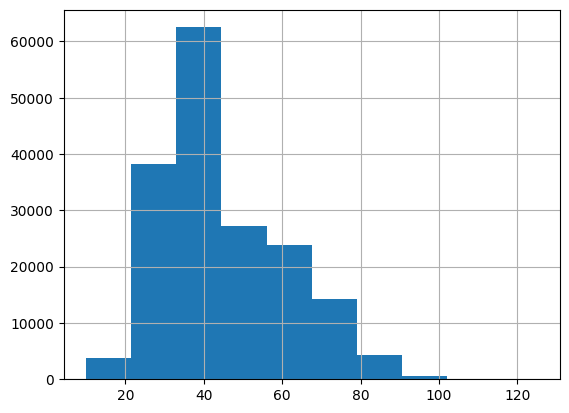

In [ ]:
test_session_yad_df["session_id"].value_counts().hist()

<Axes: >

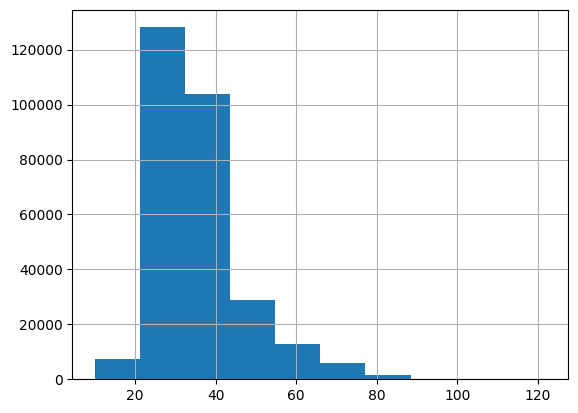

In [ ]:
train_session_yad_df["session_id"].value_counts().hist()

In [ ]:
train_session_yad_df["session_id"].value_counts()[train_session_yad_df["session_id"].value_counts() < 10]

Series([], Name: session_id, dtype: int64)

In [ ]:
# 566→324
test_session_yad_df["session_id"].value_counts()[test_session_yad_df["session_id"].value_counts() < 10]

Series([], Name: session_id, dtype: int64)

In [ ]:
print(
    test_log.filter(pl.col('session_id') == '69471c34cc4c8a3ef15856fe14aa8b7b'),
    test_log.filter(pl.col('session_id') == '6deee0ccc67d9be0efb48655494116d0')
)

shape: (1, 3)
┌──────────────────────────────────┬────────┬────────┐
│ session_id                       ┆ seq_no ┆ yad_no │
│ ---                              ┆ ---    ┆ ---    │
│ str                              ┆ i64    ┆ i64    │
╞══════════════════════════════════╪════════╪════════╡
│ 69471c34cc4c8a3ef15856fe14aa8b7b ┆ 0      ┆ 10528  │
└──────────────────────────────────┴────────┴────────┘ shape: (1, 3)
┌──────────────────────────────────┬────────┬────────┐
│ session_id                       ┆ seq_no ┆ yad_no │
│ ---                              ┆ ---    ┆ ---    │
│ str                              ┆ i64    ┆ i64    │
╞══════════════════════════════════╪════════╪════════╡
│ 6deee0ccc67d9be0efb48655494116d0 ┆ 0      ┆ 8411   │
└──────────────────────────────────┴────────┴────────┘


In [ ]:
for yad_no in [8411, 10528]:
    for input_log in [train_log, test_log]:
        print(
            input_log.filter(
                pl.col('session_id').is_in(
                    input_log.filter(pl.col('yad_no')==8411)["session_id"]
                )
            )
        )

shape: (6, 3)
┌──────────────────────────────────┬────────┬────────┐
│ session_id                       ┆ seq_no ┆ yad_no │
│ ---                              ┆ ---    ┆ ---    │
│ str                              ┆ i64    ┆ i64    │
╞══════════════════════════════════╪════════╪════════╡
│ 39ca799fe83fd728c4a1fb58a64b0779 ┆ 0      ┆ 8411   │
│ 39ca799fe83fd728c4a1fb58a64b0779 ┆ 1      ┆ 208    │
│ 4208e41976a7497631140694bd3818fe ┆ 0      ┆ 8411   │
│ 45cca1e90bb81248b89b032e1d1866c2 ┆ 0      ┆ 208    │
│ 45cca1e90bb81248b89b032e1d1866c2 ┆ 1      ┆ 8411   │
│ 6519243f65525e4acf312c8d4249bd16 ┆ 0      ┆ 8411   │
└──────────────────────────────────┴────────┴────────┘
shape: (1, 3)
┌──────────────────────────────────┬────────┬────────┐
│ session_id                       ┆ seq_no ┆ yad_no │
│ ---                              ┆ ---    ┆ ---    │
│ str                              ┆ i64    ┆ i64    │
╞══════════════════════════════════╪════════╪════════╡
│ 6deee0ccc67d9be0efb48655494116d0 ┆ 

In [ ]:
"""
# target を含まないsessionを除外
use_sess = train_session_yad_df.groupby('session_id')["target"].max()==1
use_sess = use_sess[use_sess].index
train_session_yad_df = train_session_yad_df[train_session_yad_df["session_id"].isin(use_sess)].reset_index(drop=True)
"""

'\n# target を含まないsessionを除外\nuse_sess = train_session_yad_df.groupby(\'session_id\')["target"].max()==1\nuse_sess = use_sess[use_sess].index\ntrain_session_yad_df = train_session_yad_df[train_session_yad_df["session_id"].isin(use_sess)].reset_index(drop=True)\n'

## 特徴量の作成

In [ ]:
from gensim.models import Word2Vec
from scipy.spatial.distance import euclidean


# ベクトル抽出関数
def get_vector(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros(model.vector_size)


def create_yad2vec_distance_rank_feature(input_log_df: pd.DataFrame):
    if len(input_log_df) == len(train_session_yad_df):
        tmp_log_df = train_log_df.copy()
    elif len(input_log_df) == len(test_session_yad_df):
        tmp_log_df = test_log_df.copy()

    # session_idごとにyad_noのリストを作成
    tmp_log_df['yad_no'] = tmp_log_df['yad_no'].astype(str)
    session_yad_no_sequences = tmp_log_df.groupby('session_id')['yad_no'].apply(list)

    # Word2Vecモデルのトレーニング
    model = Word2Vec(sentences=session_yad_no_sequences, vector_size=100, window=5, min_count=1, workers=4)

    _df = input_log_df.merge(tmp_log_df.groupby('session_id').tail(1)[["session_id", "yad_no"]].rename(columns={'yad_no': 'last_yad'}), on="session_id", how="left")
    _df["yad_no"] = _df["yad_no"].astype('str')

    # yad_noとlast_yadのベクトルを抽出
    yad_vectors = np.array([get_vector(yad, model) for yad in _df['yad_no']])
    last_yad_vectors = np.array([get_vector(yad, model) for yad in _df['last_yad']])

    # ユークリッド距離を計算
    distances = np.linalg.norm(yad_vectors - last_yad_vectors, axis=1)

    _df["yad2vec_distance_from_last_yad"] = distances
    out_df = _df.groupby('session_id')["yad2vec_distance_from_last_yad"].rank(ascending=False)

    assert pd.Series(out_df.index).equals(pd.Series(input_log_df.index))
    return out_df

In [ ]:
# 候補の中の地域の中でrank
# 候補の中での統計量

In [ ]:
def create_co_visit_counts_rank_feature(input_log_df: pd.DataFrame):
    # 最強
    # co_visit matrixのカウントベースの特徴
    ## NOTE: テストの特徴に欠損代わりにtrainのデータを使う路線はあり...
    if len(input_log_df) == len(train_session_yad_df):
        base_log = pl.read_csv(INPUT_DIR / "train_log.csv")
        co_visit_matrix = generate_co_visit_matrix(base_log.select(['session_id', 'yad_no']).unique())
    elif len(input_log_df) == len(test_session_yad_df):
        base_log = pl.read_csv(INPUT_DIR / "test_log.csv")
        #co_visit_matrix = generate_co_visit_matrix(base_log.select(['session_id', 'yad_no']).unique())
        leak_co_visit_counts = generate_co_visit_matrix(
            pl.concat([
                train_log.select(["session_id", "yad_no"]),
                label.select(["session_id", "yad_no"])
            ]).unique()
        ).with_columns(pl.col("co_visit_count").cast(pl.Float64))\
         .with_columns(pl.col('co_visit_count')*0.001)  #0.001

        test_co_visit_matrix = generate_co_visit_matrix(test_log.select(["session_id", "yad_no"]).unique()).with_columns(pl.col("co_visit_count").cast(pl.Float64))
        co_visit_matrix = test_co_visit_matrix.join(leak_co_visit_counts, on=["latest_yad_no", 'yad_no'], how="outer")\
                                               .rename({'co_visit_count': 'co_visit_count_left'}) \
                                               .with_columns((pl.col('co_visit_count_left').fill_null(0) + pl.col('co_visit_count_right').fill_null(0)).alias('co_visit_count'))
    else:
        print('ERRORRRRRRRRRRR')

    # testに対してはtrain混入とかするならこの辺り


    _df = input_log_df[["session_id", "yad_no"]].copy()

    outputs = []
    # 末尾のyadだけ見る / session全体の共起
    for target_log, prefix in [(base_log.group_by('session_id').last(), 'last_focus_'), (base_log.select(['session_id', 'yad_no']).unique(), 'session_unique_focus_')]:
        co_visits_next_yad_counts = target_log.join(co_visit_matrix, on=["yad_no"], how="left").rename({'yad_no': 'latest_yad_no', 'latest_yad_no': 'yad_no'})
        co_visits_next_yad_counts = co_visits_next_yad_counts.group_by(['session_id', 'yad_no']).agg(pl.col("co_visit_count").sum())
        tmp_out_df = _df.merge(co_visits_next_yad_counts.to_pandas(), on=["session_id", "yad_no"], how="left")
        tmp_out_df["co_visit_count"] = tmp_out_df["co_visit_count"].fillna(0)
        tmp_out_df["co_visit_count_in_session_rank"] = tmp_out_df.groupby('session_id')["co_visit_count"].rank(ascending=False)
        tmp_out_df["co_visit_count_in_session_sum"] = tmp_out_df["session_id"].map(tmp_out_df.groupby('session_id')["co_visit_count"].sum().to_dict())
        tmp_out_df["co_visit_count_in_session_percentage"] = np.where(tmp_out_df["co_visit_count_in_session_sum"] == 0, 0, tmp_out_df["co_visit_count"] / (tmp_out_df["co_visit_count_in_session_sum"]))

        outputs.append(
            tmp_out_df[["co_visit_count_in_session_rank", 'co_visit_count_in_session_percentage']].copy().add_prefix(prefix)
        )
    out_df = pd.concat(outputs, axis=1)
    #return last_focus_co_visits_next_yad_counts
    assert pd.Series(out_df.index).equals(pd.Series(input_log_df.index))
    return out_df

In [ ]:
def create_summary_log_numeric_rawdata(input_log_df: pd.DataFrame):
    _yado_df = yado_df.copy()
    if len(input_log_df) == len(train_session_yad_df):
        _yado_df["click_counts"] = _yado_df['train_click_counts'].copy()
    elif len(input_log_df) == len(test_session_yad_df):
        _yado_df["click_counts"] = _yado_df['test_click_counts'].copy()
    else:
        print('ERRORRRRRRRRRRR')
    _yado_df["click_counts_rank"] = _yado_df["click_counts"].rank(ascending=False)

    session_begin = whole_log_df.groupby('session_id').head(1).merge(_yado_df, on='yad_no', how='left').rename(columns={'yad_no': 'summary_yad_no'})
    session_last = whole_log_df.groupby('session_id').tail(1).merge(_yado_df, on='yad_no', how='left').rename(columns={'yad_no': 'summary_yad_no'})

    numeric_cols = ['total_room_cnt', 'click_counts', 'click_counts_rank']  # train/testによって中身は異なる
    session_mean = whole_log_df[["session_id", "yad_no"]].drop_duplicates().merge(_yado_df, on='yad_no', how='left').groupby('session_id')[numeric_cols].mean()

    outputs = []
    for session_summary_log, position_name in [(session_begin, 'begin'), (session_last, 'last'), (session_mean, 'mean')]:
        session_summary_log = input_log_df.merge(session_summary_log, on='session_id', how='left')
        tmp_df_out = session_summary_log[['total_room_cnt', 'click_counts_rank']].copy()  #  いらんかも
        # 差分
        candidate_data = input_log_df.merge(_yado_df, on='yad_no', how='left')
        for num_col in ['total_room_cnt']:
            tmp_df_out[f'{num_col}_div'] = session_summary_log[num_col] / candidate_data[num_col]   # click counts用
            tmp_df_out[f'{num_col}_diff'] = session_summary_log[num_col] - candidate_data[num_col]   # rank用
        num_col = 'click_counts'
        tmp_df_out[f'{num_col}_div'] = session_summary_log[num_col] / candidate_data[num_col]   # click counts用
        num_col = 'click_counts_rank'
        tmp_df_out[f'{num_col}_diff'] = session_summary_log[num_col] - candidate_data[num_col]   # rank用
        outputs.append(tmp_df_out.add_prefix(f'{position_name}log_'))

    out_df = pd.concat(outputs, axis=1)

    assert pd.Series(out_df.index).equals(pd.Series(input_log_df.index))
    return out_df

In [ ]:
def create_summary_log_categorical_rawdata(input_log_df: pd.DataFrame):
    session_begin = whole_log_df.groupby('session_id').head(1).merge(yado_df, on='yad_no', how='left').rename(columns={'yad_no': 'summary_yad_no'})
    session_last = whole_log_df.groupby('session_id').tail(1).merge(yado_df, on='yad_no', how='left').rename(columns={'yad_no': 'summary_yad_no'})

    outputs = []
    for session_summary_log, position_name in [(session_begin, 'begin'), (session_last, 'last')]:
        session_summary_log = input_log_df.merge(session_summary_log, on='session_id', how='left')

        tmp_df_out = session_summary_log[['summary_yad_no', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd']].astype('category').copy()
        outputs.append(tmp_df_out.add_prefix(f'{position_name}log_'))

    out_df = pd.concat(outputs, axis=1)

    assert pd.Series(out_df.index).equals(pd.Series(input_log_df.index))
    return out_df

In [ ]:
def create_in_session_order_feature(input_df: pd.DataFrame):
    # session中に複数回同じyad_noを見ていた時用の特徴
    # session中にclickした回数
    # オリジナルのclickデータから特徴生成
    out_df = pd.DataFrame()
    in_session_click_counts_feature = input_df.merge(
        whole_log_df.groupby(['session_id', 'yad_no']).size().rename('in_session_click_counts').reset_index()
        , on=["session_id", "yad_no"], how="left"
    )["in_session_click_counts"].fillna(-1)

    # session中で対象のyad_noに対するseq_noのmin
    in_session_min_seq_no_feature = input_df.merge(
        whole_log_df.groupby(['session_id', 'yad_no'])["seq_no"].min().rename('min_seq_no').reset_index()
        , on=["session_id", "yad_no"], how="left"
    )["min_seq_no"].fillna(-1)

    # session中で対象のyad_noに対するseq_noのmax
    in_session_max_seq_no_feature = input_df.merge(
        whole_log_df.groupby(['session_id', 'yad_no'])["seq_no"].max().rename('max_seq_no').reset_index()
        , on=["session_id", "yad_no"], how="left"
    )["max_seq_no"].fillna(-1)

    # 順番によって正解わかるみたいなやつ
    tmp = whole_log_df.copy()
    tmp["reverse_seq_no"] = tmp["session_id"].map(whole_log_df.groupby('session_id')["seq_no"].max()) - tmp["seq_no"]
    tmp["seq_no_magic_feature"] = np.where(tmp["reverse_seq_no"] == 1, 1, 0)

    in_session_max_reverse_seq_no_feature = input_df.merge(
        tmp.groupby(['session_id', 'yad_no'])["reverse_seq_no"].max().rename('max_reverse_seq_no').reset_index()
        , on=["session_id", "yad_no"], how="left"
    )["max_reverse_seq_no"].fillna(-1)

    seq_no_magic_feature = input_df.merge(
        #tmp[["session_id", "yad_no", "seq_no_magic_feature"]].drop_duplicates().reset_index()
        tmp.groupby(['session_id', "yad_no"])["seq_no_magic_feature"].max()
        , on=["session_id", "yad_no"], how="left"
    )["seq_no_magic_feature"].fillna(-1)

    out_df = pd.concat([in_session_click_counts_feature.astype('int8'),
                         in_session_min_seq_no_feature.astype('int8'),
                         in_session_max_seq_no_feature.astype('int8'),
                         in_session_max_reverse_seq_no_feature.astype('int8'),
                         #(in_session_max_reverse_seq_no_feature % 2).rename('max_reverse_seq_no_mod2').fillna(-1).astype('int8'),
                         seq_no_magic_feature.astype('int8'),
                         ], axis=1)

    assert pd.Series(out_df.index).equals(pd.Series(input_df.index))
    return out_df

#assert create_in_session_order_feature(train_session_yad_df).equals(create_in_session_order_feature(train_session_yad_df))
#assert create_in_session_order_feature(train_session_yad_df).shape[0] == train_session_yad_df.shape[0]
#v = create_in_session_order_feature(train_session_yad_df)

In [ ]:
def create_region_click_counts_rank_feature(input_log_df):
    # yado_dfにあるクリック系の特徴量ベース
    yado_pl = pl.read_csv(INPUT_DIR / "yado.csv")
    if len(input_log_df) == len(train_session_yad_df):
        log_pl = pl.read_csv(INPUT_DIR / "train_log.csv")
        TARGET_COL = 'train_click_counts'
    elif len(input_log_df) == len(test_session_yad_df):
        log_pl = pl.read_csv(INPUT_DIR / "test_log.csv")
        TARGET_COL = 'test_click_counts'
    else:
        print('ERRORRRRRRRRRRR')

    outputs = []
    for reg_col in tqdm(['sml_cd', 'lrg_cd', 'ken_cd', 'wid_cd']):
        # 人気の定義はtrain / test でのクリック数
        # 地域の中でクリック回数
        col_rename = f'{reg_col}_click_counts_rank'
        region_click_rank_meta = pd.concat([
            yado_df["yad_no"],
            yado_df.groupby(reg_col).rank(ascending=False)[TARGET_COL].rename(col_rename)
        ], axis=1)
        # 入力にmerge
        tmp_out = input_log_df.merge(region_click_rank_meta, on="yad_no", how="left")
        # 値そのまま
        outputs.append(tmp_out[col_rename])
        # session内部でのrank
        outputs.append(tmp_out.groupby('session_id').rank(ascending=False)[[col_rename]].add_suffix('_in_session'))

    col_rename = f'click_counts_rank'
    click_rank_meta = pd.concat([
        yado_df["yad_no"],
        yado_df[TARGET_COL].rank(ascending=False).rename(col_rename)
    ], axis=1)
    tmp_out = input_log_df.merge(click_rank_meta, on="yad_no", how="left")
    outputs.append(tmp_out[col_rename])
    outputs.append(tmp_out.groupby('session_id').rank(ascending=False)[[col_rename]].add_suffix('_in_session'))

    out_df = pd.concat(outputs, axis=1)
    assert pd.Series(out_df.index).equals(pd.Series(input_log_df.index))
    return out_df

In [ ]:
def create_normalize_yad_click_counts(input_log_df: pd.DataFrame):
    # この特徴量だったら 数値計算諸々やってもいいかも
    if len(input_log_df) == len(train_session_yad_df):
        TARGET_COL = 'train_click_counts'
    elif len(input_log_df) == len(test_session_yad_df):
        TARGET_COL = 'test_click_counts'

    _yado_df = yado_df.copy()
    for reg_col in ['sml_cd', 'lrg_cd', 'ken_cd', 'wid_cd']:
        _yado_df[f'click_counts_sum_in_{reg_col}'] = _yado_df[reg_col].map(_yado_df.groupby(reg_col)[TARGET_COL].sum().to_dict())
        _yado_df[f'click_counts_prob_in_{reg_col}'] = np.where(_yado_df[f'click_counts_sum_in_{reg_col}'] == 0, _yado_df[TARGET_COL] / 1.0, _yado_df[TARGET_COL] / _yado_df[f'click_counts_sum_in_{reg_col}'])

    _yado_df['click_counts_prob_overall'] = _yado_df[TARGET_COL] / _yado_df[TARGET_COL].sum()
    _yado_df = pd.concat([
        _yado_df[["yad_no"]],
        _yado_df.filter(regex='click_counts_prob')
    ], axis=1)

    out_df = input_log_df.merge(_yado_df, on="yad_no", how="left").filter(regex='click_counts_prob')
    assert pd.Series(out_df.index).equals(pd.Series(input_log_df.index))
    return out_df

In [ ]:
v = create_normalize_yad_click_counts(train_session_yad_df)
v.corr()

,click_counts_prob_in_sml_cd,click_counts_prob_in_lrg_cd,click_counts_prob_in_ken_cd,click_counts_prob_in_wid_cd,click_counts_prob_overall
click_counts_prob_in_sml_cd,1.000000,0.682130,0.319446,0.262348,0.384510
click_counts_prob_in_lrg_cd,0.682130,1.000000,0.501661,0.403040,0.409972
click_counts_prob_in_ken_cd,0.319446,0.501661,1.000000,0.669659,0.554007
click_counts_prob_in_wid_cd,0.262348,0.403040,0.669659,1.000000,0.632275
click_counts_prob_overall,0.384510,0.409972,0.554007,0.632275,1.000000


In [ ]:
v2 = create_normalize_yad_click_counts(test_session_yad_df)
v2.corr()

,click_counts_prob_in_sml_cd,click_counts_prob_in_lrg_cd,click_counts_prob_in_ken_cd,click_counts_prob_in_wid_cd,click_counts_prob_overall
click_counts_prob_in_sml_cd,1.000000,0.683782,0.370798,0.359892,0.372045
click_counts_prob_in_lrg_cd,0.683782,1.000000,0.585206,0.544697,0.483537
click_counts_prob_in_ken_cd,0.370798,0.585206,1.000000,0.746645,0.629073
click_counts_prob_in_wid_cd,0.359892,0.544697,0.746645,1.000000,0.724823
click_counts_prob_overall,0.372045,0.483537,0.629073,0.724823,1.000000


In [ ]:
def create_session_length_feature(input_df: pd.DataFrame):
    # オリジナルのclickデータから特徴生成
    session_length = whole_log_df.groupby("session_id")["seq_no"].max().rename("session_length")

    # wid_cdとかのunique数
    reg_unique = whole_log_df.merge(yado_df, on="yad_no", how="left")[['session_id', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd']].groupby('session_id').nunique()

    out_df = pd.concat([
        pd.merge(input_df["session_id"], session_length, on="session_id", how="left").drop(columns=["session_id"]),
        pd.merge(input_df["session_id"], reg_unique, on="session_id", how="left").drop(columns=["session_id"]).add_suffix('_nunique'),
    ], axis=1)

    for c in ['wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd']:
        out_df[f'{c}_div_sess_length'] = out_df[f'{c}_nunique'] / (out_df["session_length"] + 1)

    assert pd.Series(out_df.index).equals(pd.Series(input_df.index))
    return out_df.astype('int8')

assert create_session_length_feature(train_session_yad_df).equals(create_session_length_feature(train_session_yad_df))

In [ ]:
def create_next_click_feature(input_log_df: pd.DataFrame):
    # trainのデータ混入の余地あり

    if len(input_log_df) == len(train_session_yad_df):
        log_pl = pl.read_csv(INPUT_DIR / "train_log.csv")
        FOLD_NUM = -1
    elif len(input_log_df) == len(test_session_yad_df):
        print('test')
        log_pl = pl.read_csv(INPUT_DIR / "test_log.csv")
        #FOLD_NUM = -2
        FOLD_NUM = -3
    else:
        print('ERRORRRRRRRRRRR')
    session2_last_yad = log_pl.join(log_pl.group_by('session_id').agg(pl.col('seq_no').max()), on="session_id", how="left") \
                               .filter(pl.col('seq_no') == pl.col('seq_no_right')) \
                               .select(['session_id', 'yad_no'])

    session2_next_click_counts = session2_last_yad.join(next_click_counts_pl.filter(pl.col('fold')==FOLD_NUM), on="yad_no", how="left") \
                                                    .select(['session_id', 'next_yad_no', 'count']).rename({'next_yad_no': 'yad_no'}).unique()
    tmp_df_out = input_log_df.merge(session2_next_click_counts.to_pandas(), on=["session_id", "yad_no"], how="left").fillna(0)


    tmp_df_out["in_session_next_click_sum"] = tmp_df_out["session_id"].map(tmp_df_out.groupby('session_id')["count"].sum().to_dict())
    tmp_df_out["next_click_count_rank"] = tmp_df_out.groupby('session_id')["count"].rank(ascending=False)
    tmp_df_out["in_session_next_click_prob"] = np.where(tmp_df_out["in_session_next_click_sum"] == 0, 0, tmp_df_out["count"] / (tmp_df_out["in_session_next_click_sum"]))



    # 末尾のyadに対して逆方向
    reverse_next_click_counts_pl = next_click_counts_pl.filter(pl.col('fold')==FOLD_NUM).rename({'next_yad_no': 'yad_no', 'yad_no': 'next_yad_no'})\
                                                .group_by(['yad_no', 'next_yad_no']).agg(pl.col("count").sum()).sort(['yad_no', 'next_yad_no'])
    session2_reverse_next_click_counts = session2_last_yad.join(reverse_next_click_counts_pl, on="yad_no", how="left") \
                                                             .select(['session_id', 'next_yad_no', 'count']).rename({'next_yad_no': 'yad_no'}).unique()

    tmp_df_out2 = input_log_df.merge(session2_reverse_next_click_counts.to_pandas(), on=["session_id", "yad_no"], how="left").fillna(0)

    tmp_df_out2["in_session_next_click_sum"] = tmp_df_out2["session_id"].map(tmp_df_out2.groupby('session_id')["count"].sum().to_dict())
    tmp_df_out2["next_click_count_rank"] = tmp_df_out2.groupby('session_id')["count"].rank(ascending=False)
    tmp_df_out2["in_session_next_click_prob"] = np.where(tmp_df_out2["in_session_next_click_sum"] == 0, 0, tmp_df_out2["count"] / (tmp_df_out2["in_session_next_click_sum"]))




    out_df = pd.concat([
        tmp_df_out[["next_click_count_rank", "in_session_next_click_prob"]],
        tmp_df_out2[["next_click_count_rank", "in_session_next_click_prob"]].add_prefix('reverse_')
    ], axis=1)
    assert pd.Series(out_df.index).equals(pd.Series(input_log_df.index))
    return out_df

In [ ]:
def create_yado_numaric_feature(input_df: pd.DataFrame):
    num_columns = [
        'yad_type',
        'total_room_cnt',
        'wireless_lan_flg',
        'onsen_flg',
        'kd_stn_5min',
        'kd_bch_5min',
        'kd_slp_5min',
        'kd_conv_walk_5min',

        'exterior',
        'facility',
        'food',
        'others',
        'room',
        'num_total_images',
    ]

    # key となる `yad_no` を付与するのをお忘れなく.
    out_df = pd.merge(input_df["yad_no"], yado_df[["yad_no", *num_columns]], how="left").drop(columns=["yad_no"])
    # out_df["null_image_field_counts"] = (out_df[['exterior', 'facility', 'food', 'others', 'room']] == 0).sum(axis=1)
    assert pd.Series(out_df.index).equals(pd.Series(input_df.index))
    return out_df


assert create_yado_numaric_feature(train_session_yad_df).equals(
    create_yado_numaric_feature(train_session_yad_df)
)

In [ ]:
def create_yad_categorical_feature(input_df: pd.DataFrame):

    out_df = pd.merge(input_df["yad_no"], yado_df[["yad_no", 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd']], how="left").astype('category')  # .drop(columns=["yad_no"])
    assert pd.Series(out_df.index).equals(pd.Series(input_df.index))

    return out_df

In [ ]:
def create_option_yad_and_last_yado_is_same_region_feature(input_df):

    # 0: 地域のカラム名を指定(あとでべつの列でもできるように!)
    outputs = []
    for region_column in ['wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd']:
        # 1: セッション宿に地域を紐づけ
        session_yad_region_df = pd.merge(input_df,
                                            yado_df[["yad_no", region_column]], on="yad_no", how="left")

        # 2: ログデータを使って, セッションの一番最後のレコードに地域を紐づけ
        #   - セッションの一番最後の行のみを取り出して
        last_session_yad_df = whole_log_df.groupby("session_id")["yad_no"].last().reset_index()

        #   - 宿マスターから地域を紐づけ
        last_session_yad_df = pd.merge(last_session_yad_df, yado_df[["yad_no", region_column]], on="yad_no", how="left")

        # 3: セッション宿のセッションに, 一番最後の宿の地域を紐づけ
        last_yad_region = pd.merge(session_yad_region_df["session_id"],
                                last_session_yad_df[["session_id", region_column]],
                                how="left")[region_column]

        # 4: 1 と 3 の地域が一致している == 一番最後の宿の地域と候補の宿の地域が一緒!
        idx = session_yad_region_df[region_column] == last_yad_region

        outputs.append(
            pd.DataFrame({
                "same": idx.astype(int)
            }).add_prefix(f"{region_column}_is_")
        )
    out_df = pd.concat(outputs, axis=1)

    assert pd.Series(out_df.index).equals(pd.Series(input_df.index))
    return out_df

In [ ]:
def create_session_meta_matching(input_df: pd.DataFrame):
    # オリジナルのclickデータから特徴生成
    #base_df = whole_log_df.groupby('session_id').tail(1).groupby(['session_id','yad_no']).size().rename('counts').reset_index() \
    base_df = whole_log_df.groupby(['session_id','yad_no']).size().rename('counts').reset_index() \
                            .merge(yado_df, on=["yad_no"], how="left")[["session_id", "yad_no", 'counts', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd']]
    base_df = pl.from_pandas(base_df)
    session_yad_meta = input_df.merge(yado_df, on=["yad_no"], how="left")[["session_id", "yad_no", 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd']]
    session_yad_meta = pl.from_pandas(session_yad_meta)
    region_columns = ['wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd']

    result_df = pd.DataFrame()
    for reg_col in region_columns:

        # pivot_table の作成. 縦がsession， 横がreg_val
        agg_table = base_df.pivot(index='session_id', columns=reg_col, values='counts', aggregate_function='sum').fill_null(0)
        # 'session_id' 以外の列を int8 にキャスト
        agg_table = agg_table.with_columns([pl.col(col).cast(pl.Int8) for col in agg_table.columns if col != 'session_id'])

        df_out = pl.DataFrame()
        for region_val in tqdm(agg_table.columns):
            if region_val != 'session_id':
                # matchするsessionの抽出とマーカー列の追加
                matched_sessions = agg_table.filter(pl.col(region_val) > 0).select('session_id').with_columns(pl.lit(True).alias('is_in_matched_sessions'))

                # session_yad_metaとの結合
                joined = session_yad_meta.join(matched_sessions, on='session_id', how='left')

                # リージョンカラムがregion_valと一致するかどうかを確認し、結合されたマーカー列を使用してマッチするsession_idを判断
                is_match = joined.with_columns(((pl.col(reg_col) == region_val) & pl.col('is_in_matched_sessions').is_not_null()).cast(pl.Int8).alias(f'{reg_col}_{region_val}_match')) \
                                .select(f'{reg_col}_{region_val}_match')

                df_out = df_out.hstack(is_match)

        # 各リージョンカラムに対するマッチの合計
        match_columns = [col for col in df_out.columns if col.startswith(f'{reg_col}_')]
        result_df[f'{reg_col}_match'] = df_out.sum_horizontal().to_pandas()

    assert pd.Series(result_df.index).equals(pd.Series(input_df.index))
    return result_df

In [ ]:
from sklearn.decomposition import TruncatedSVD

image_df = pd.read_parquet(os.path.join(INPUT_DIR, "image_embeddings.parquet"))

# 今回は 32 次元にすることにしました
img_svd = TruncatedSVD(n_components=12, random_state=41)

emb_columns = [s for s in image_df.columns.tolist() if "emb" in s]
z = img_svd.fit_transform(image_df[emb_columns].values)
print(z.shape)
svd_img_df = pd.concat([
    image_df[["yad_no", "category"]],
    pd.DataFrame(data=z)
], axis=1)
mean_svd_df = svd_img_df.groupby(["yad_no"]).mean().add_prefix('image_embedding_')


def create_yado_image_feature(input_df):
    out_df = input_df.merge(mean_svd_df, on="yad_no", how="left").filter(regex='embedding')

    assert pd.Series(out_df.index).equals(pd.Series(input_df.index))
    return out_df

(178406, 12)


<ipython-input-42-f32451551afc>:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_svd_df = svd_img_df.groupby(["yad_no"]).mean().add_prefix('image_embedding_')


In [ ]:
%%time
from scipy import sparse
from scipy.sparse.linalg import svds


def create_click_svd_feature(input_df: pd.DataFrame):
    # オリジナルのclickデータから特徴生成
    #_df = whole_log_df.groupby(['session_id', 'yad_no']).size().rename('click_counts').reset_index()
    #_df["click_counts"] = _df["click_counts"].astype('int8')
    #_df['session_id'] = _df['session_id'].astype('category')
    #_df['yad_no'] = _df['yad_no'].astype('category')

    if len(input_df) == len(train_session_yad_df):
        _df = train_log_df[["session_id", "yad_no"]].drop_duplicates().reset_index(drop=True)
        _df = _df.groupby(['session_id', 'yad_no']).size().rename('click_counts').reset_index()
    elif len(input_df) == len(test_session_yad_df):
        # test
        _df = pd.concat([train_log_df, train_label_df], axis=0, ignore_index=True)[["session_id", "yad_no"]].drop_duplicates().reset_index(drop=True)
        _df = _df.groupby(['session_id', 'yad_no']).size().rename('click_counts').reset_index()
        _df["click_counts"] = (_df["click_counts"] * 0.1).astype('float16')

        _test_df = test_log_df[["session_id", "yad_no"]].drop_duplicates().reset_index(drop=True)
        _test_df = _test_df.groupby(['session_id', 'yad_no']).size().rename('click_counts').reset_index()
        _test_df["click_counts"]  = _test_df["click_counts"].astype('float16')

        _df = pd.concat([_df, _test_df], axis=0, ignore_index=True)
    print(_df.shape)
    _df['session_id'] = _df['session_id'].astype('category')
    _df['yad_no'] = _df['yad_no'].astype('category')


    # スパース行列の作成
    row = _df['session_id'].cat.codes
    col = _df['yad_no'].cat.codes
    data = _df['click_counts']
    sparse_matrix = sparse.coo_matrix((data, (row, col)), shape=(len(_df['session_id'].cat.categories), len(_df['yad_no'].cat.categories)))

    # Truncated SVDの実行
    N_COMPONENTS = 64  # 大きくしてもいいかも
    u, s, vt = svds(sparse_matrix.astype(float), k=N_COMPONENTS, random_state=42)  # kは成分の数
    print(u.shape, s.shape, vt.shape)

    # session_id と yad_no のユニークな値の取得
    unique_session_ids = _df['session_id'].cat.categories
    unique_yad_nos = _df['yad_no'].cat.categories

    s_matrix = np.diag(s)
    # session_id とそのベクトルの辞書
    session_dict = {session_id: u[i] for i, session_id in enumerate(unique_session_ids)}
    # yad_no とそのベクトルの辞書
    yad_dict = {yad_no: vt.T[i] for i, yad_no in enumerate(unique_yad_nos)}

    sess2_last_yad = whole_log_df.groupby('session_id').tail(1).set_index('session_id')["yad_no"].to_dict()
    svd_df = pd.concat([
        input_df["session_id"].map(session_dict),
        input_df["session_id"].map(sess2_last_yad).map(yad_dict).rename('last_yad_emb'),
        input_df["yad_no"].map(yad_dict)
    ], axis=1)

    # まず、null の場所を識別
    null_idx = svd_df["session_id"].isnull() | svd_df["yad_no"].isnull()

    # s_matrix を変換して、適用しやすい形にする
    s_matrix_diag = np.diag(s_matrix)

    # session_id と yad_no のベクトルをリストとして抽出
    session_vectors = svd_df["session_id"].to_list()
    yad_vectors = svd_df["yad_no"].to_list()

    # 内積の計算
    # 各行に対してベクトル化された内積を計算
    inner_product = [np.dot(sess, s_matrix.dot(yad)) if not is_null else np.nan
                    for sess, yad, is_null in tqdm(zip(session_vectors, yad_vectors, null_idx))]
    # 結果を DataFrame に追加
    svd_df["sess_yad_svd_product"] = inner_product


    last_yad_vectors = svd_df["last_yad_emb"].to_list()
    # 各行に対してベクトル化された内積を計算
    yad_yad_distance = [np.linalg.norm(sess - yad) if not is_null else np.nan
                    for sess, yad, is_null in tqdm(zip(last_yad_vectors, yad_vectors, null_idx))]
    svd_df["svd_emb_distance_from_last_yad"] = yad_yad_distance

    import gc
    gc.collect()

    """
    out_df = pd.concat([
        input_df,
        svd_df["sess_yad_svd_product"]
    ],axis=1)
    """
    out_df = pd.concat([
        input_df["session_id"],
        svd_df["sess_yad_svd_product"].copy(),
        svd_df["svd_emb_distance_from_last_yad"].copy(),
    ], axis=1)
    out_df["sess_yad_svd_product_rank"] = out_df.groupby('session_id')["sess_yad_svd_product"].rank(ascending=False)
    out_df["svd_emb_distance_from_last_yad_rank"] = out_df.groupby('session_id')["svd_emb_distance_from_last_yad"].rank(ascending=False)

    out_df = out_df[["sess_yad_svd_product_rank", "svd_emb_distance_from_last_yad_rank"]].copy()

    assert pd.Series(out_df.index).equals(pd.Series(input_df.index))
    return out_df

CPU times: user 22 µs, sys: 0 ns, total: 22 µs
Wall time: 25.7 µs


In [ ]:
def create_sparse_session_meta_feature():
    _df['session_id'] = _df['session_id'].astype('category')
    _df['yad_no'] = _df['yad_no'].astype('category')


    # スパース行列の作成
    row = _df['session_id'].cat.codes
    col = _df['yad_no'].cat.codes
    data = _df['click_counts']
    sparse_matrix = sparse.coo_matrix((data, (row, col)), shape=(len(_df['session_id'].cat.categories), len(_df['yad_no'].cat.categories)))

    # Truncated SVDの実行
    N_COMPONENTS = 64  # 大きくしてもいいかも
    u, s, vt = svds(sparse_matrix.astype(float), k=N_COMPONENTS, random_state=42)  # kは成分の数
    print(u.shape, s.shape, vt.shape)

    # session_id と yad_no のユニークな値の取得
    unique_session_ids = _df['session_id'].cat.categories
    unique_yad_nos = _df['yad_no'].cat.categories

    s_matrix = np.diag(s)
    # session_id とそのベクトルの辞書
    session_dict = {session_id: u[i] for i, session_id in enumerate(unique_session_ids)}
    # yad_no とそのベクトルの辞書
    yad_dict = {yad_no: vt.T[i] for i, yad_no in enumerate(unique_yad_nos)}



def create_session_meta_aggregate(input_df: pd.DataFrame):
    # オリジナルのclickデータから特徴生成
    base_df = whole_log_df[['session_id','yad_no']].drop_duplicates().groupby(['session_id','yad_no']).size().rename('counts').reset_index() \
                            .merge(yado_df, on=["yad_no"], how="left")[["session_id", "yad_no", 'counts', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd']]
    region_columns = ['wid_cd']#, 'ken_cd']#, 'lrg_cd', 'sml_cd']
    outputs = []
    for reg_col in tqdm(region_columns):
        agg_table = pd.pivot_table(base_df, values='counts', index=['session_id'],
                                    columns=[reg_col], aggfunc="sum").fillna(0).astype('int8')
        outputs.append(
            pd.merge(input_df["session_id"], agg_table, on="session_id", how="left").drop(columns=["session_id"]).add_prefix(f'{reg_col}_')
        )
    out_df = pd.concat(outputs, axis=1)
    assert pd.Series(out_df.index).equals(pd.Series(input_df.index))
    return out_df

# t = create_session_meta_aggregate(train_session_yad_df)

### 特徴量のマージ

上記の特徴量作成関数を連続的に呼び出し & 結合して、学習に使う特徴量全体にしましょう。

In [ ]:
# いままでの関数をすべてがっちゃんこして特徴量を作成する関数を定義しましょう!

def create_feature(input_df):

    # functions に特徴量作成関数を配列で定義しました.
    # どの関数も同じ input / output のインターフェイスなので for で回せて嬉しいですね ;)
    functions = [
        create_in_session_order_feature,
        create_session_length_feature,
        create_next_click_feature,
        create_yado_numaric_feature,
        create_yad_categorical_feature,  # yad_noとかは少し不安
        create_region_click_counts_rank_feature,
        create_summary_log_categorical_rawdata,  # cv下がった．LB上がった
        #create_region_quality_rank_feature,
        create_summary_log_numeric_rawdata,  # click系使っているので不安です
        create_co_visit_counts_rank_feature,  # cv上がった. 以外とLB微妙
        create_session_meta_matching,  #session全体
        create_option_yad_and_last_yado_is_same_region_feature,  # 最後のyadの地域
        # create_yado_image_feature,  # これ消すver.は一回やった方が良さそう
        create_normalize_yad_click_counts,  # train / testでcorrが良く． 綺麗な特徴にみえる
        create_click_svd_feature,
        create_session_meta_aggregate,
        create_yad2vec_distance_rank_feature,

    ]

    out_df = pd.DataFrame()
    for func in functions:
        func_name = str(func.__name__)
        with Timer(prefix=f"- create {func_name}"):
            _df = func(input_df)
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [ ]:
#create_feature(train_session_yad_df.head(50))

In [ ]:
# 実行して train / test 用の特徴量を作ります.

with Timer(prefix="train..."):
    train_feat_df = create_feature(train_session_yad_df)

with Timer(prefix="test..."):
    test_feat_df = create_feature(test_session_yad_df)

#X = train_feat_df.values
y = train_session_yad_df["target"].values

- create create_in_session_order_feature 30.204[s]
- create create_session_length_feature 7.291[s]
- create create_next_click_feature 32.928[s]
- create create_yado_numaric_feature 2.200[s]
- create create_yad_categorical_feature 6.349[s]


100%|██████████| 4/4 [00:40<00:00, 10.16s/it]


- create create_region_click_counts_rank_feature 51.814[s]
- create create_summary_log_categorical_rawdata 24.047[s]
- create create_summary_log_numeric_rawdata 33.323[s]
- create create_co_visit_counts_rank_feature 33.967[s]


100%|██████████| 538/538 [03:14<00:00,  2.77it/s]


- create create_session_meta_matching 343.468[s]
- create create_option_yad_and_last_yado_is_same_region_feature 22.650[s]
- create create_normalize_yad_click_counts 2.257[s]
(398151, 3)
(288698, 64) (64,) (64, 13372)


10361235it [00:55, 186039.27it/s]
10361235it [01:02, 166640.55it/s]


- create create_click_svd_feature 141.758[s]


100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


- create create_session_meta_aggregate 3.990[s]
- create create_yad2vec_distance_rank_feature 69.696[s]
train... 823.235[s]
- create create_in_session_order_feature 20.805[s]
- create create_session_length_feature 5.225[s]
test
- create create_next_click_feature 26.392[s]
- create create_yado_numaric_feature 1.407[s]
- create create_yad_categorical_feature 4.321[s]


100%|██████████| 4/4 [00:24<00:00,  6.24s/it]


- create create_region_click_counts_rank_feature 31.985[s]
- create create_summary_log_categorical_rawdata 17.005[s]
- create create_summary_log_numeric_rawdata 24.331[s]
- create create_co_visit_counts_rank_feature 27.258[s]


100%|██████████| 538/538 [02:29<00:00,  3.59it/s]


- create create_session_meta_matching 266.830[s]
- create create_option_yad_and_last_yado_is_same_region_feature 17.628[s]
- create create_normalize_yad_click_counts 1.300[s]
(837252, 3)
(463398, 64) (64,) (64, 13806)


7789529it [00:42, 184410.89it/s]
7789529it [00:45, 171540.61it/s]


- create create_click_svd_feature 110.154[s]


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


- create create_session_meta_aggregate 3.468[s]
- create create_yad2vec_distance_rank_feature 61.281[s]
test... 631.499[s]


In [ ]:
train_feat_df.isnull().sum().sort_values().tail(20)

sml_cd                                   0
yad2vec_distance_from_last_yad           0
wid_cd                                   0
lrg_cd                                   0
ken_cd                                   0
meanlog_total_room_cnt              245733
beginlog_total_room_cnt             349582
lastlog_total_room_cnt              356833
total_room_cnt                      356959
meanlog_total_room_cnt_diff         589438
meanlog_total_room_cnt_div          589446
beginlog_total_room_cnt_diff        685409
beginlog_total_room_cnt_div         685445
lastlog_total_room_cnt_div          694880
lastlog_total_room_cnt_diff         694880
wireless_lan_flg                   1103833
kd_conv_walk_5min                  1708031
kd_stn_5min                        3973976
kd_bch_5min                       10118720
kd_slp_5min                       10311598
dtype: int64

In [ ]:
train_feat_df.columns

Index(['in_session_click_counts', 'min_seq_no', 'max_seq_no',
       'max_reverse_seq_no', 'seq_no_magic_feature', 'session_length',
       'wid_cd_nunique', 'ken_cd_nunique', 'lrg_cd_nunique', 'sml_cd_nunique',
       ...
       'wid_cd_46e33861f921c3e38b81998fbf283f01',
       'wid_cd_89e181a40914767dfee00fa2b7c2dcb5',
       'wid_cd_8a1c0d3243bba111cbcd1ec6c692dc6d',
       'wid_cd_b07b75d367ebece55a23ceecc939fff4',
       'wid_cd_c312e07b7a5d456d53a5b00910a336e1',
       'wid_cd_d86102dd9c232bade9a97dccad40df48',
       'wid_cd_dc414a17890cfc17d011d5038b88ca93',
       'wid_cd_e9316013ee1b03f4525fe361c46ce9c5',
       'wid_cd_f0112abf369fb03cdc5f5309300913da',
       'yad2vec_distance_from_last_yad'],
      dtype='object', length=107)

In [ ]:
train_feat_df.head()

,in_session_click_counts,min_seq_no,max_seq_no,max_reverse_seq_no,seq_no_magic_feature,session_length,wid_cd_nunique,ken_cd_nunique,lrg_cd_nunique,sml_cd_nunique,...,wid_cd_46e33861f921c3e38b81998fbf283f01,wid_cd_89e181a40914767dfee00fa2b7c2dcb5,wid_cd_8a1c0d3243bba111cbcd1ec6c692dc6d,wid_cd_b07b75d367ebece55a23ceecc939fff4,wid_cd_c312e07b7a5d456d53a5b00910a336e1,wid_cd_d86102dd9c232bade9a97dccad40df48,wid_cd_dc414a17890cfc17d011d5038b88ca93,wid_cd_e9316013ee1b03f4525fe361c46ce9c5,wid_cd_f0112abf369fb03cdc5f5309300913da,yad2vec_distance_from_last_yad
0,-1,-1,-1,-1,-1,0,1,1,1,1,...,0,0,0,0,0,0,1,0,0,18.0
1,-1,-1,-1,-1,-1,0,1,1,1,1,...,0,0,0,0,0,0,1,0,0,29.0
2,-1,-1,-1,-1,-1,0,1,1,1,1,...,0,0,0,0,0,0,1,0,0,15.0
3,-1,-1,-1,-1,-1,0,1,1,1,1,...,0,0,0,0,0,0,1,0,0,17.0
4,-1,-1,-1,-1,-1,0,1,1,1,1,...,0,0,0,0,0,0,1,0,0,6.0


In [ ]:
assert (train_feat_df.columns == test_feat_df.columns).sum() == len(train_feat_df.columns)

## モデルの学習

### LightGBM による CrossValidation を用いた学習

In [ ]:
import lightgbm as lgbm
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, f1_score, mean_absolute_error, mean_squared_error, \
    r2_score, mean_squared_log_error, median_absolute_error, explained_variance_score, cohen_kappa_score, \
    average_precision_score, precision_score, recall_score


def binary_metrics(y_true: np.ndarray,
                   predict_probability: np.ndarray,
                   threshold=.5) -> dict:
    """
    calculate binary task metrics
    Args:
        y_true:
            target. shape = (n_data,)
        predict_probability:
            predict value. be probability prediction for log_loss, roc_auc, etc.
        threshold:
            Thresholds for calculating the metrics that need to be evaluated as labels
    Returns:
        metrics metrics dictionary. the key is metric name, and the value is score.
    """
    predict_label = np.where(predict_probability > threshold, 1, 0)
    none_prob_functions = [
        accuracy_score,
        f1_score,
        precision_score,
        recall_score
    ]

    prob_functions = [
        roc_auc_score,
        log_loss,
        average_precision_score
    ]

    scores = {}
    for f in none_prob_functions:
        score = f(y_true, predict_label)
        scores[str(f.__name__)] = score
    for f in prob_functions:
        score = f(y_true, predict_probability)
        scores[f.__name__] = score

    return scores

def fit_lgbm(X,
             y,
             cv,
             params: dict=None,
             cv_groups: list=None):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        print(f"-- start fold {i}")
        if isinstance(X, pd.DataFrame):
            x_train, y_train = X.iloc[idx_train], y[idx_train]
            x_valid, y_valid = X.iloc[idx_valid], y[idx_valid]
        elif isinstance(X, np.ndarray):
            x_train, y_train = X[idx_train], y[idx_train]
            x_valid, y_valid = X[idx_valid], y[idx_valid]


        if params["objective"] == "lambdarank":
            df_train = lgbm.Dataset(x_train, y_train, group=cv_groups[i][0])
            df_valid = lgbm.Dataset(x_valid, y_valid, group=cv_groups[i][1])
            #clf = lgbm.LGBMRanker(**params)
            with Timer(prefix="fit fold={} ".format(i)):
                # cv 内で train に定義された x_train で学習する
                model = lgbm.train(
                    params,
                    df_train,
                    valid_sets=[df_train, df_valid],
                    valid_names=["train_df", "valid_df"],
                    callbacks=[
                        lgbm.early_stopping(stopping_rounds=100, verbose=False),
                        lgbm.log_evaluation(period=100, ),
                    ],
                )
            # ランキングモデルでの推論
            pred_i = model.predict(x_valid)
            oof_pred[idx_valid] = pred_i
            models.append(model)
            # スコア計算（ランキングモデルに適したメトリクスを使用する）
            score = binary_metrics(y_valid, pred_i)
            print(f" - fold{i} - {score}")

        else:
            clf = lgbm.LGBMClassifier(**params, verbose=0)

            with Timer(prefix="fit fold={} ".format(i)):
                # cv 内で train に定義された x_train で学習する
                clf.fit(x_train, y_train,
                        eval_set=[(x_train, y_train), (x_valid, y_valid)],
                        callbacks=[
                            lgbm.early_stopping(stopping_rounds=100, verbose=False),
                            lgbm.log_evaluation(period=100, ),
                        ],)

            # cv 内で validation data とされた x_valid で予測をして oof_pred に保存していく
            # oof_pred は全部学習に使わなかったデータの予測結果になる → モデルの予測性能を見る指標として利用できる
            pred_i = clf.predict_proba(x_valid)[:, 1]
            oof_pred[idx_valid] = pred_i
            models.append(clf)
            score = binary_metrics(y_valid, pred_i)
            print(f" - fold{i + 1} - {score}")

    score = binary_metrics(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score}")
    return oof_pred, models

In [ ]:
base_index = train_session_yad_df.index
_cv = [(np.array(base_index[train_session_yad_df["fold"]!=i_fold]), np.array(base_index[train_session_yad_df["fold"]==i_fold])) for i_fold in range(5)]

cv_groups = [(train_session_yad_df[train_session_yad_df["fold"]!=i_fold].groupby('session_id').size().values,
               train_session_yad_df[train_session_yad_df["fold"]==i_fold].groupby('session_id').size().values) for i_fold in range(5)]

import gc
gc.collect()

30

In [ ]:
params = {
    "objective": "binary",
    #"objective": "lambdarank",

    #"metric": "auc",
    "n_estimators": 10000,
    "learning_rate": .1,
    "num_leaves": 7,
    "bagging_fraction": .6,
    "min_data_in_leaf": 2000,  # 200

    "importance_type": "gain",
    "random_state": SEED,
}


#oof, models = fit_lgbm(X, y=y, params=params, cv=_cv, cv_groups=cv_groups)
oof, models = fit_lgbm(train_feat_df, y=y, params=params, cv=_cv, cv_groups=cv_groups)

-- start fold 0
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[100]	training's binary_

# 評価

In [ ]:
def create_top_10_yad_predict(predict, session_yad_df):
    _df = pd.concat([session_yad_df[["session_id", "yad_no"]], pd.Series(predict, name="predict")], axis=1)

    # セッションごとに予測確率の高い順に yad_no の配列を作成
    _agg = _df.sort_values("predict", ascending=False).groupby("session_id")["yad_no"].apply(list)

    out_df = pd.DataFrame(index=_agg.index, data=_agg.values.tolist()).iloc[:, :10]

    return out_df

In [ ]:
oof_label_df = create_top_10_yad_predict(predict=oof, session_yad_df=train_session_yad_df)

oof_label_df

,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,
000007603d533d30453cc45d0f3d119f,2808,11882,5289,4101,997,12846,5821,7157,1648,12837
0000ca043ed437a1472c9d1d154eb49b,8253,11104,4488,2570,1586,8747,6602,13717,3725,2259
0000d4835cf113316fe447e2f80ba1c8,9039,5238,13642,918,7509,9854,6676,2957,11031,6722
0000fcda1ae1b2f431e55a7075d1f500,626,13549,11715,755,1341,7812,1169,121,109,12785
000104bdffaaad1a1e0a9ebacf585f33,96,3894,7749,11380,902,5490,12491,1908,12338,10905
...,...,...,...,...,...,...,...,...,...,...
ffff2262d38abdeb247ebd591835dcc9,2876,3725,1586,13717,8992,8677,3564,5179,9881,5719
ffff2360540745117193ecadcdc06538,4767,5299,3940,8703,2900,8465,399,513,963,6654
ffff7fb4617164b2604aaf51c40bf82d,12240,7308,4040,4398,7820,7057,2087,3566,9558,6630


In [ ]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k for a single actual value.

    Parameters:
    actual : int
        The actual value that is to be predicted
    predicted : list
        A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The average precision at k
    """
    if actual in predicted[:k]:
        return 1.0 / (predicted[:k].index(actual) + 1)
    return 0.0

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k for lists of actual values and predicted values.

    Parameters:
    actual : list
        A list of actual values that are to be predicted
    predicted : list
        A list of lists of predicted elements (order does matter in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The mean average precision at k
    """
    return sum(apk(a, p, k) for a, p in zip(actual, predicted)) / len(actual)

In [ ]:
# いま作成した session_id と同じ並びで train_label を並び替え
train_label = train_label_df.set_index("session_id").loc[oof_label_df.index]["yad_no"].values

In [ ]:
# MAPK (k=10) として計算
mapk(actual=train_label, predicted=oof_label_df.values.tolist(), k=10)

0.39507693792603077

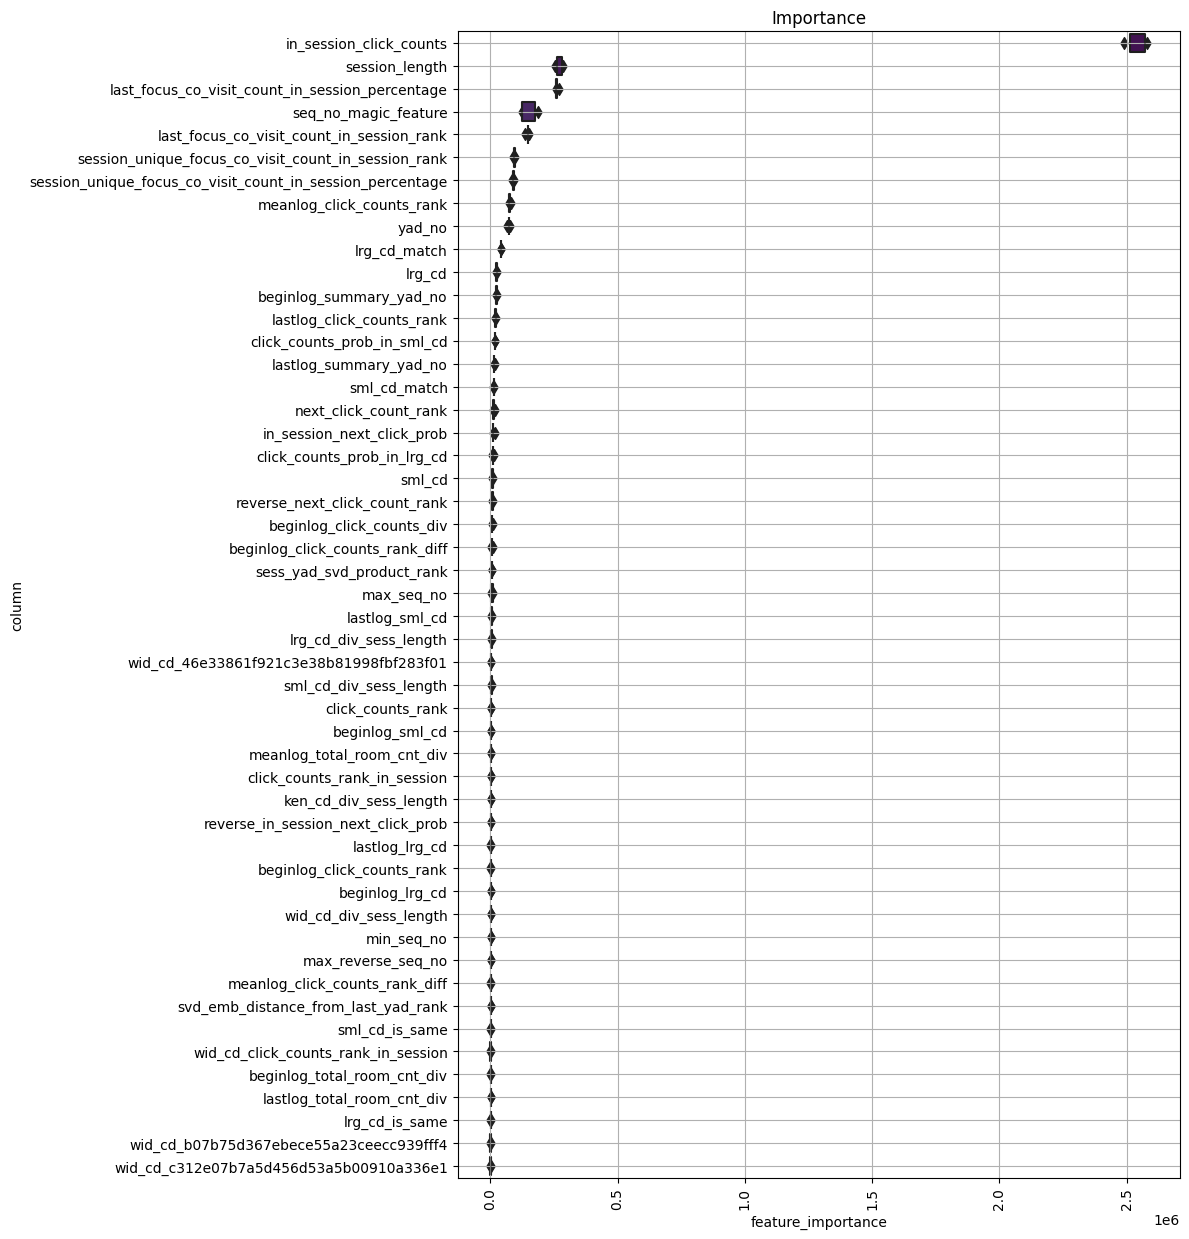

In [ ]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        try:
            _df["feature_importance"] = model.feature_importances_
        except:
            _df["feature_importance"] = model.feature_importance()
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df,
                  x="feature_importance",
                  y="column",
                  order=order,
                  ax=ax,
                  palette="viridis",
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_feat_df)

これを見ると `total_room_cnt` によって説明される要素が大きいようです。具体的に差分を seaborn.boxenplot で見てみましょう。

(0.0, 5.0)

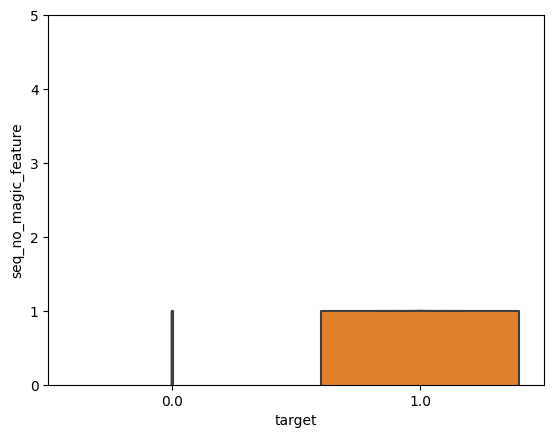

In [ ]:
col = "seq_no_magic_feature"
ax = sns.boxenplot(data=pd.DataFrame({
    col: train_feat_df[col],
    "target": y
}), x="target", y=col)

ax.set_ylim([0, 5])

これを見ると予約される宿のほうが部屋数の分布が上に偏っているように見えます。部屋が大きい宿のほうが予約されやすいようです。(単に部屋が多い == そもそも予約のキャパも大きいので予約されやすい、ということかもしれませんね)

#### Future Work

* 他の列についても同様に考察をしてみると新たなインサイトが得られるかもしれません。やってみましょう!

## 推論する

学習したモデルを使ってテストデータに対しての予測を行いましょう。

In [ ]:
# k 個のモデルの予測確率 (predict_proba) を作成. shape = (5, N_test,).
if params["objective"] == "binary":
    #pred_prob = np.array([model.predict_proba(test_feat_df.values)[:, 1] for model in models])
    pred_prob = np.array([model.predict_proba(test_feat_df)[:, 1] for model in models])
elif params["objective"] == "lambdarank":
    #pred_prob = np.array([model.predict(test_feat_df.values) for model in models])
    pred_prob = np.array([model.predict(test_feat_df) for model in models])

[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_dat

In [ ]:
pred_prob

array([[1.04265106e-04, 1.06939629e-04, 1.24398054e-04, ...,
        2.11909450e-03, 1.12975013e-02, 1.61149216e-02],
       [1.08889180e-04, 9.80664235e-05, 1.27071720e-04, ...,
        2.47490119e-03, 9.62901285e-03, 1.72841325e-02],
       [7.96574096e-05, 4.97381875e-05, 1.10844757e-04, ...,
        2.11854625e-03, 8.01351860e-03, 1.56063884e-02],
       [1.22977091e-04, 9.96930299e-05, 1.55692811e-04, ...,
        2.41143755e-03, 9.76780736e-03, 1.65334362e-02],
       [8.46278496e-05, 9.63009934e-05, 1.43080374e-04, ...,
        3.27661631e-03, 1.10132430e-02, 1.99497564e-02]])

In [ ]:
# k 個のモデルの予測値の平均 shape = (N_test,).
pred_prob = np.mean(pred_prob, axis=0) # axis=0 なので shape の `k` が潰れる

# 生値の保存


In [ ]:
oof_save = train_session_yad_df.copy()
oof_save["score"] = oof
oof_save.to_csv(os.path.join(OUTPUT_DIR, f"{EXP_NAME}_oof.csv"), index=False)

In [ ]:
test_pred_raw_save = test_session_yad_df.copy()
test_pred_raw_save["score"] = pred_prob
test_pred_raw_save.to_csv(os.path.join(OUTPUT_DIR, f"{EXP_NAME}_pred_raw.csv"), index=False)

### 予測値の確認

予測結果が学習時の結果と差が出ていないかを確認しましょう。具体的には out of fold の予測確率の分布と test への予測確率の分布を見て大きなズレがないかなどを見ると良いです。このとき予期せぬズレが発生している場合には実装が間違っている場合や、テスト時に使えない情報を学習時に使っている場合などがあります。

勢い良く submit をする前に一度確認しておくと良いです🫑( '-' 🫑)

In [ ]:
oof

array([0.03980128, 0.01884176, 0.03227213, ..., 0.00124848, 0.00180953,
       0.00063531], dtype=float32)

In [ ]:
#sns.histplot(oof)

In [ ]:
#sns.histplot(pred_prob)

In [ ]:
tmp_test_log = pd.read_csv(INPUT_DIR / "test_log.csv")
candidate_idx = test_session_yad_df.merge(
    tmp_test_log.groupby('session_id').tail(1), on=["session_id", "yad_no"], how="left"
)["seq_no"].isnull()

In [ ]:
#_test_pred_df = create_top_10_yad_predict(predict=pred_prob, session_yad_df=test_session_yad_df)
test_pred_df = create_top_10_yad_predict(predict=pred_prob[candidate_idx], session_yad_df=test_session_yad_df[candidate_idx].reset_index(drop=True))
test_pred_df.iloc[:, :10].fillna(0).astype(int).add_prefix("predict_").to_csv(os.path.join(OUTPUT_DIR, f"{EXP_NAME}_submission.csv"), index=False)

In [ ]:
test_pred_df.head()

,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,
00001149e9c73985425197104712478c,3560,4420,11561,2680,5466,4714,9534,6488,10233,7461
0000e02747d749a52b7736dfa751e258,7014,8108,6129,11923,4066,143,5055,11237,9323,10095
0000f17ae2628237d78d3a38b009d3be,757,7710,9190,9910,13570,1774,410,6721,6862,10485
000174a6f7a569b84c5575760d2e9664,12341,6991,3359,13521,1542,10861,4180,5657,10746,9319
00017e2a527901c9c41b1acef525d016,2862,763,9020,11480,5650,1448,13235,607,6161,12524


In [ ]:
test_pred_df.isnull().sum(axis=0)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64

In [ ]:
test_pred_df[test_pred_df.isnull().sum(axis=1) > 0]

,0,1,2,3,4,5,6,7,8,9
session_id,,,,,,,,,,


In [ ]:
tmp = test_session_yad_df.copy()
tmp["predict"] = pred_prob
tmp.head(20)

,session_id,yad_no,predict
0,00001149e9c73985425197104712478c,170,0.000100
1,00001149e9c73985425197104712478c,337,0.000090
2,00001149e9c73985425197104712478c,360,0.000132
3,00001149e9c73985425197104712478c,379,0.000041
4,00001149e9c73985425197104712478c,385,0.000051
5,00001149e9c73985425197104712478c,584,0.000118
6,00001149e9c73985425197104712478c,755,0.000066
7,00001149e9c73985425197104712478c,930,0.000241
8,00001149e9c73985425197104712478c,1063,0.000078
9,00001149e9c73985425197104712478c,1286,0.000326


In [ ]:
null_sess = test_pred_df[test_pred_df.isnull().sum(axis=1) > 2].index
tmp[tmp["session_id"].isin(null_sess)].head(30)

,session_id,yad_no,predict


In [ ]:
#train_feat_df["click_conversion_pair_counts"]

In [ ]:
#train_log_df.head(40)
train_log_df[train_log_df["session_id"]=='fffe8a472ae6a96c9da05a30ac3ed6c5']

,session_id,seq_no,yad_no,fold
419257,fffe8a472ae6a96c9da05a30ac3ed6c5,0,4353,2
419258,fffe8a472ae6a96c9da05a30ac3ed6c5,1,11321,2
419259,fffe8a472ae6a96c9da05a30ac3ed6c5,2,6810,2


In [ ]:
#tmp[tmp["session_id"]=='fffe8a472ae6a96c9da05a30ac3ed6c5']
tmp_oof = train_session_yad_df.copy()
tmp_oof["oof"] = oof
#tmp_oof["click_conversion_pair_counts"] = train_feat_df["click_conversion_pair_counts"]
#tmp_oof["cv_per_click"] = train_feat_df["cv_per_click"]
#tmp_oof["click_count"] = train_feat_df["click_count"]
tmp_oof[tmp_oof["session_id"]=='fffe8a472ae6a96c9da05a30ac3ed6c5']

,session_id,yad_no,target,fold,oof
10360996,fffe8a472ae6a96c9da05a30ac3ed6c5,377,0.0,2,0.003516
10360997,fffe8a472ae6a96c9da05a30ac3ed6c5,496,0.0,2,0.000025
10360998,fffe8a472ae6a96c9da05a30ac3ed6c5,837,0.0,2,0.000096
10360999,fffe8a472ae6a96c9da05a30ac3ed6c5,1368,0.0,2,0.000403
10361000,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,0.0,2,0.000845
10361001,fffe8a472ae6a96c9da05a30ac3ed6c5,2227,0.0,2,0.000080
10361002,fffe8a472ae6a96c9da05a30ac3ed6c5,2977,0.0,2,0.043905
10361003,fffe8a472ae6a96c9da05a30ac3ed6c5,3217,0.0,2,0.000099
10361004,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,0.0,2,0.000627
10361005,fffe8a472ae6a96c9da05a30ac3ed6c5,4353,1.0,2,0.559714


In [ ]:
#test_log_df.head(40)
test_log_df[test_log_df["session_id"]=='000174a6f7a569b84c5575760d2e9664']

,session_id,seq_no,yad_no
5,000174a6f7a569b84c5575760d2e9664,0,13610
6,000174a6f7a569b84c5575760d2e9664,1,12341
7,000174a6f7a569b84c5575760d2e9664,2,13610


In [ ]:
tmp[tmp["session_id"]=='000174a6f7a569b84c5575760d2e9664']#.sort_values('predict')

,session_id,yad_no,predict
144,000174a6f7a569b84c5575760d2e9664,255,0.000023
145,000174a6f7a569b84c5575760d2e9664,277,0.000527
146,000174a6f7a569b84c5575760d2e9664,1542,0.004406
147,000174a6f7a569b84c5575760d2e9664,2047,0.000148
148,000174a6f7a569b84c5575760d2e9664,2237,0.000065
149,000174a6f7a569b84c5575760d2e9664,2363,0.000094
150,000174a6f7a569b84c5575760d2e9664,2795,0.000472
151,000174a6f7a569b84c5575760d2e9664,3359,0.016930
152,000174a6f7a569b84c5575760d2e9664,3750,0.000125
153,000174a6f7a569b84c5575760d2e9664,4180,0.001978
